In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import g0

In [2]:
def load_report(path):
    return np.fromfile(path, sep = ' ').reshape((-1,7))

mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

In [3]:
pre = load_report('orbit/tcm4/Tianwen1_preTCM4.txt')
post = load_report('orbit/tcm4/Tianwen1_postTCM4.txt')[::-1]
t = np.datetime64('1970-01-01') + (mjd2unixtimestamp(pre[:,0]) * 1e9) * np.timedelta64(1, 'ns')

In [4]:
post_interp = np.empty_like(pre)
post_interp[:,0] = pre[:,0]
for j in range(1, post_interp.shape[1]):
    post_interp[:,j] = np.interp(post_interp[:,0], post[:,0], post[:,j], left = np.nan, right = np.nan)

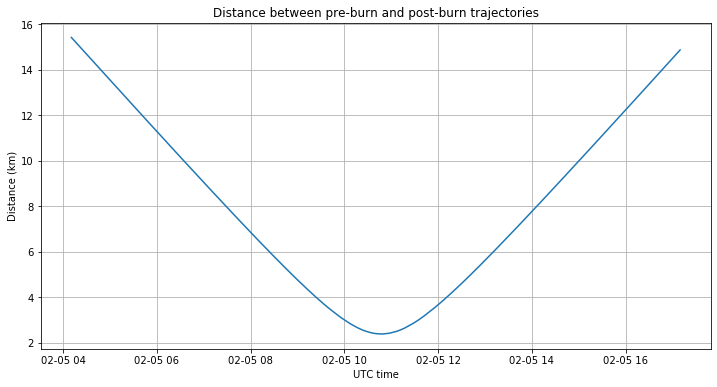

In [5]:
plt.figure(figsize = (12,6), facecolor = 'w')
dist = np.sqrt(np.sum((pre[:,1:4] - post_interp[:,1:4])**2, axis = 1))
plt.plot(t, dist)
plt.grid()
plt.title('Distance between pre-burn and post-burn trajectories')
plt.xlabel('UTC time')
plt.ylabel('Distance (km)');

In [6]:
sel = ~np.isnan(dist)
burn_idx = np.argmin(dist[sel])
t[sel][burn_idx]

numpy.datetime64('2021-02-05T10:47:51.467000320')

In [7]:
dist[sel][burn_idx]

2.3866622340850205

In [8]:
delta_v_ms = (post_interp[sel][burn_idx, 4:] - pre[sel][burn_idx, 4:]) * 1e3
delta_v_ms

array([ 0.49150875,  0.29430668, -0.28538354])

In [9]:
delta_v_norm = np.sqrt(np.sum(delta_v_ms**2))
delta_v_norm

0.6400320585278245

In [10]:
# Burn of 8x 25N
F = 8*25
T = 480
m = 5000
# approximate time
delta_v_norm*m/F

16.00080146319561

In [11]:
# Specific energy, from GMAT
E = 3.1021265267617 * u.km**2 / u.s**2
# periapsis velocity, from GMAT
v_peri = 5.3593181628708 * u.km / u.s
mu = 4.2828372e13 * u.m**3 / u.s**2 # Mars GM
T_capture = 11 * u.day # taken from mission plan
E_capture = (-0.5*(2*np.pi*mu/T_capture)**(2/3)).to(u.km**2/u.s**2)
delta_Ek = E_capture - E

In [12]:
# delta-V for capture
capture_deltaV = (v_peri - np.sqrt(v_peri**2 + 2*delta_Ek)).to(u.m/u.s)
capture_deltaV

<Quantity 659.65362139 m / s>

In [13]:
# delta-V for parabolic capture
parabolic_deltaV = (v_peri - np.sqrt(v_peri**2 - 2*E)).to(u.m/u.s)
parabolic_deltaV

<Quantity 614.00066903 m / s>

In [14]:
Isp = 321.6 * u.s
m0 = 4430 * u.kg # estimate

In [15]:
mf = np.exp(-capture_deltaV / (Isp * g0)) * m0
delta_m = m0 - mf
delta_m

<Quantity 836.09521931 kg>

In [16]:
mdot = (3e3 * u.N / (Isp * g0)).to(u.kg/u.s)
mdot

<Quantity 0.95122781 kg / s>

In [17]:
burn_time = delta_m / mdot
burn_time

<Quantity 878.96422916 s>